# Lung Cancer Classification

We'll be using data from a 1991 study in China (https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer?resource=download). The data includes 15 predictor variables and a boolean variable for lung cancer. Most of these features are binary, the only numerical variable is `Age`.

## [Video Presentation](https://youtu.be/0PDVMmlsg1E)


## Questions
1.   Which factors affect the risk for lung cancer?
2.   How does the risk change if the person is a smoker/non-smoker and drinker/non-drinker?
3.   What are the best performing models for predicting lung cancer with the available data?

# Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install inflection
from inflection import underscore

In [ ]:
df = pd.read_csv("https://gist.githubusercontent.com/biblock/c6c6fa7e25fe3de80bf73be8bdd41ef0/raw/1af32e46c3a1894530165fa704f849721d18422c/lung_cancer.csv")
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
# rename columns to snake_case
df.rename(columns={col: underscore(col.strip(' ').replace(' ', '_')) for col in df.columns}, inplace=True)
df.head()
df.columns

Index(['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety',
       'peer_pressure', 'chronic_disease', 'fatigue', 'allergy', 'wheezing',
       'alcohol_consuming', 'coughing', 'shortness_of_breath',
       'swallowing_difficulty', 'chest_pain', 'lung_cancer'],
      dtype='object')

In [ ]:
# change numerical boolean values from 2 and 1 to 1 and 0
# subtract 1 from all numerical columns other than age
numeric_cols = [col for col in df if df[col].dtype.kind != 'O' and col != 'AGE']
df[numeric_cols] -= 1

In [ ]:
# change LUNG_CANCER boolean to YES = 1, NO = 0
df['lung_cancer'] = (df['lung_cancer'] == 'YES') * 1

# change GENDER to M = 1, F = 0
df['gender'] = (df['gender'] == 'M') * 1

In [ ]:
df.head()

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
0,1,68,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,73,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,58,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,62,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,62,0,1,0,0,0,0,0,1,0,1,1,0,0,0


# Data Exploration

Around *87.4%* of our data points are positive for `lung_cancer`. We need to consider this
when choosing classification models.

1    270
0     39
Name: lung_cancer, dtype: int64
1    0.873786
0    0.126214
Name: lung_cancer, dtype: float64


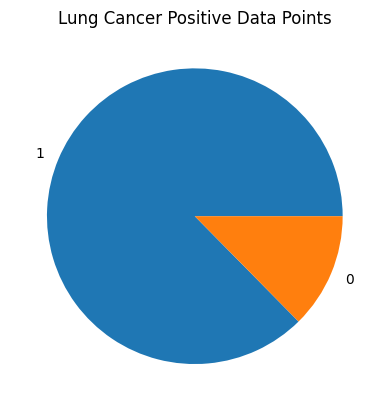

In [ ]:
df['lung_cancer'].value_counts().plot.pie(ylabel='', title='Lung Cancer Positive Data Points', )
print(df['lung_cancer'].value_counts())
print(df['lung_cancer'].value_counts(normalize=True))

Distribution of `age` grouped by `lung_cancer`

lung_cancer
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: age, dtype: object

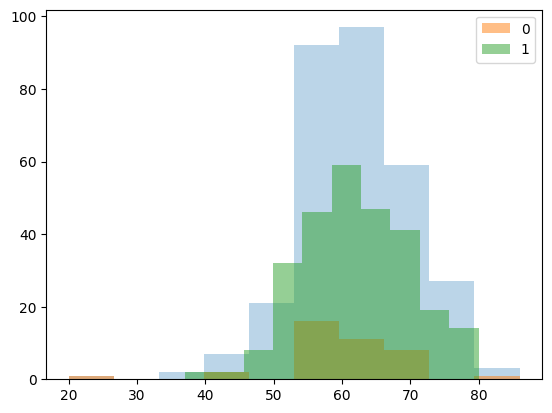

In [ ]:
df['age'].hist(grid=False, alpha=0.3)
df.groupby('lung_cancer')['age'].hist(grid=False, alpha=0.5, legend=True)

<Axes: title={'center': 'age'}, xlabel='lung_cancer'>

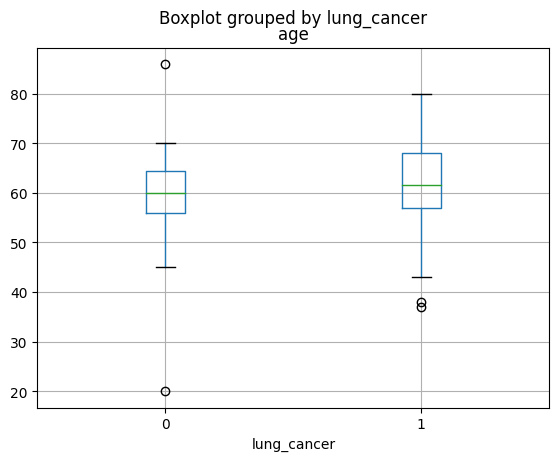

In [ ]:
df.boxplot(column='age' ,by='lung_cancer')

In [ ]:
# create a column containing the total number of predictors
df['total_predictors'] = df.sum(axis=1) - df['age'] - df['lung_cancer'] - df['gender']

**Which factors affect the risk for lung cancer?**


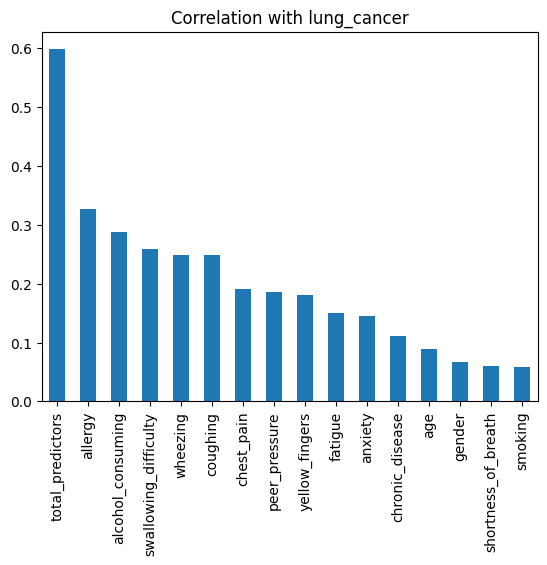

In [ ]:
# plot correlation with lung_cancer
corrs = df.corr()['lung_cancer'].sort_values(ascending=False)
corrs = corrs[corrs < 1]

corrs.plot(kind="bar", title="Correlation with lung_cancer")
plt.show()

<Axes: title={'center': 'total_predictors'}, xlabel='lung_cancer'>

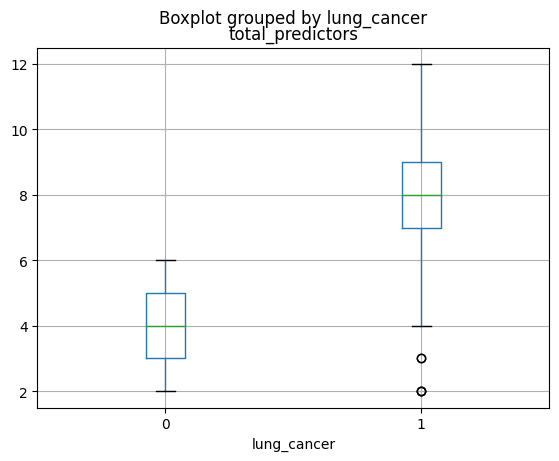

In [ ]:
df.boxplot(column='total_predictors', by='lung_cancer')

# the total number of predictors seems to be a good estimate of lung cancer

2         Axes(0.1,0.679412;0.235294x0.220588)
3    Axes(0.382353,0.679412;0.235294x0.220588)
4    Axes(0.664706,0.679412;0.235294x0.220588)
5         Axes(0.1,0.414706;0.235294x0.220588)
6    Axes(0.382353,0.414706;0.235294x0.220588)
7    Axes(0.664706,0.414706;0.235294x0.220588)
8             Axes(0.1,0.15;0.235294x0.220588)
dtype: object

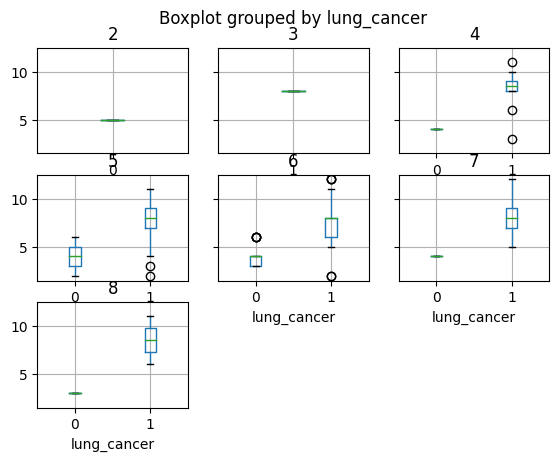

In [ ]:
df['age_decade'] = df['age'] // 10

df.groupby('age_decade').boxplot(column='total_predictors', by='lung_cancer', )

# this pattern remains across all age groups

# Classification
We want to use a model that can handle imbalanced classes and doesn't require a lot of data since most observations are positive for `lung_cancer` and we only have 309 observations.

Some good options for this are
- Logistic Regression: Simple, interpretable, good with binary variables
- Random Forest: Robust to overfitting, more accurate, but more complex and less interpretable
- Gradient Boosting Machines (GBM): More accurate but more complex


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

X_train = df[['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety', 'peer_pressure', 'chronic_disease', 'fatigue', 'allergy', 'wheezing', 'alcohol_consuming', 'coughing', 'shortness_of_breath', 'swallowing_difficulty', 'chest_pain']]
y_train = df['lung_cancer']

### Logistic Regression
F1: `0.9510988077025813`

0.9510988077025813


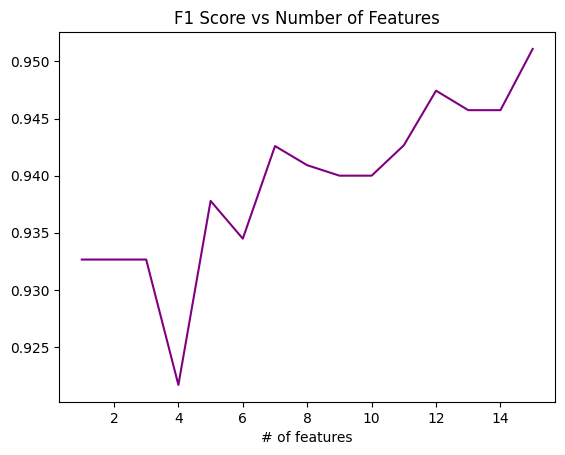

In [ ]:
from sklearn.linear_model import LogisticRegression

corrs.drop('total_predictors', inplace=True)

feature_set = corrs.index

f1_lst = []

for comb in range(len(corrs)):
  X_train = df[feature_set[:comb+1]]

  scores = cross_val_score(
    LogisticRegression(solver='liblinear', max_iter=1000),
    X = X_train,
    y = y_train,
    scoring = "f1",
    cv=5
  )
  f1_lst.append(scores.mean())

df_f1 = pd.DataFrame(f1_lst, columns=['F1'])
df_f1['# of features'] = range(1,16)
df_f1.plot.line(x='# of features', y='F1', c='purple', legend=False, title='F1 Score vs Number of Features')

print(df_f1['F1'][14])
# the model performs better with more variables

#### Drinking and Smoking vs Lung Cancer (Logistic Regression)
The bar graph here looks rather daunting due to the data mostly coming from positive `lung_cancer` data points. This can be scaled to give a relative probability risk of `lung_cancer`.

**How does the risk change if the person is a smoker/non-smoker and drinker/non-drinker?**

<Axes: title={'center': 'Drinking and Smoking vs Lung Cancer Prediction'}, xlabel='alcohol_consuming,smoking'>

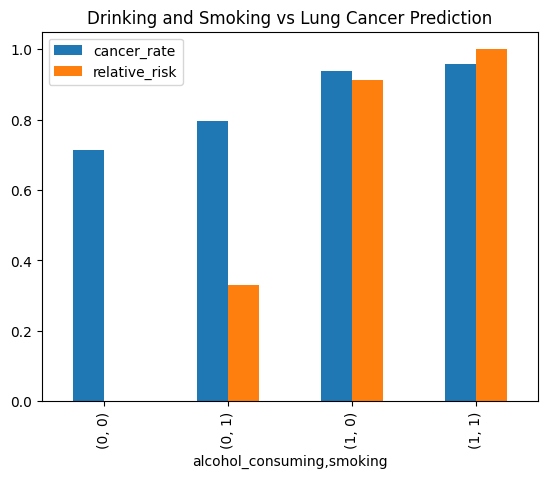

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

X_drug_train = df[['alcohol_consuming', 'smoking']]
y_drug_train = df['lung_cancer']

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', max_iter=1000)
)

pipeline.fit(X_drug_train, y_drug_train)
probas = pd.DataFrame(pipeline.predict_proba(X_drug_train), columns=[0, 'cancer_rate'])['cancer_rate']
df_predicted_probas = X_drug_train.join(probas).groupby(['alcohol_consuming', 'smoking']).mean()

scaler = MinMaxScaler()
df_predicted_probas['relative_risk'] = scaler.fit_transform(df_predicted_probas.values.reshape(-1, 1))

df_predicted_probas.plot.bar(title='Drinking and Smoking vs Lung Cancer Prediction')

### Random Forest

#### Using Default Hyperparameters
F1: `0.9540434406472142`

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = RandomForestClassifier()

pipeline = make_pipeline(StandardScaler(), model)

rf_scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    scoring='f1',
    cv=5
)

rf_scores.mean()

0.9557808923846659

In [ ]:
pipeline.named_steps

{'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier()}

#### Using Hyperparameter Tuning
F1: `0.9578815406321033`

In [ ]:
# commented out so that it is not accidentally run
'''
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    pipeline,
    {'randomforestclassifier__n_estimators': range(50, 120, 6),
     'randomforestclassifier__class_weight': ['balanced', None],
     'randomforestclassifier__max_depth': [None, 10, 25],
     'randomforestclassifier__min_samples_split': [2, 5, 10],
     'randomforestclassifier__min_samples_leaf': [1, 2, 4],
     'randomforestclassifier__max_features': [None, 'sqrt', 'log2'],
     'randomforestclassifier__bootstrap': [True, False]},
    scoring='f1',
    cv=5
)

gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_
'''

# This took an hour to run

# Output:
# ({'randomforestclassifier__bootstrap': True,
#   'randomforestclassifier__class_weight': 'balanced',
#   'randomforestclassifier__max_depth': 25,
#   'randomforestclassifier__max_features': 'log2',
#   'randomforestclassifier__min_samples_leaf': 1,
#   'randomforestclassifier__min_samples_split': 2,
#   'randomforestclassifier__n_estimators': 68},
#  0.9578815406321033)

"\nfrom sklearn.model_selection import GridSearchCV\n\ngs = GridSearchCV(\n    pipeline,\n    {'randomforestclassifier__n_estimators': range(50, 120, 6),\n     'randomforestclassifier__class_weight': ['balanced', None],\n     'randomforestclassifier__max_depth': [None, 10, 25],\n     'randomforestclassifier__min_samples_split': [2, 5, 10],\n     'randomforestclassifier__min_samples_leaf': [1, 2, 4],\n     'randomforestclassifier__max_features': [None, 'sqrt', 'log2'],\n     'randomforestclassifier__bootstrap': [True, False]},\n    scoring='f1',\n    cv=5\n)\n\ngs.fit(X_train, y_train)\ngs.best_params_, gs.best_score_\n"

## Gradient Boosting Machine (GBM)

#### Using Default Hyperparameters
F1: `0.9404461253682722`

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

model = GradientBoostingClassifier()

gb_scores = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='f1',
    cv=5
)

gb_scores.mean()

0.9404461253682722

#### Using Hyperparameter Tuning
F1: `0.9597472797472797`

In [ ]:
# commented out so that it is not accidentally run
'''
gs = GridSearchCV(
    model,
    {'n_estimators': [20, 50, 100, 200],
     'subsample': [0.4, 0.8, 1.0],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4],
     'max_depth': [None, 1, 3, 5],
     'max_features': [None, 'sqrt', 'log2']},
    scoring='f1',
    cv=5
)

gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_
'''
# This took 15 minutes to run

# Output:
# ({'max_depth': 5,
#   'max_features': 'sqrt',
#   'min_samples_leaf': 1,
#   'min_samples_split': 5,
#   'n_estimators': 100,
#   'subsample': 0.4},
#  0.9597472797472797)

"\ngs = GridSearchCV(\n    model,\n    {'n_estimators': [20, 50, 100, 200],\n     'subsample': [0.4, 0.8, 1.0],\n     'min_samples_split': [2, 5, 10],\n     'min_samples_leaf': [1, 2, 4],\n     'max_depth': [None, 1, 3, 5],\n     'max_features': [None, 'sqrt', 'log2']},\n    scoring='f1',\n    cv=5\n)\n\ngs.fit(X_train, y_train)\ngs.best_params_, gs.best_score_\n"

# Our Findings
**What are the best performing models for predicting lung cancer with the available data?**
*   *Logistic Regression:* `0.9510988077025813`
*   *Default Random Forest Classifier:* `0.9540434406472142`
*   *Tuned Random Forest Classifier:* `0.9578815406321033`
*   *Default Gradient Boosting Classifier:* `0.9404461253682722`
*   ***Tuned Gradient Boosting Classifier:* `0.9597472797472797`**

We can see that model performance increases as model complexity increases, but the improvements are minor. The Logistic Regressor performed nearly as well as the Tuned Gradient Boosting Classifier. For this case, the simple model might be the best choice since the model is more interpretable than the more complex ones.

<Axes: title={'center': 'F1 Score of Models'}>

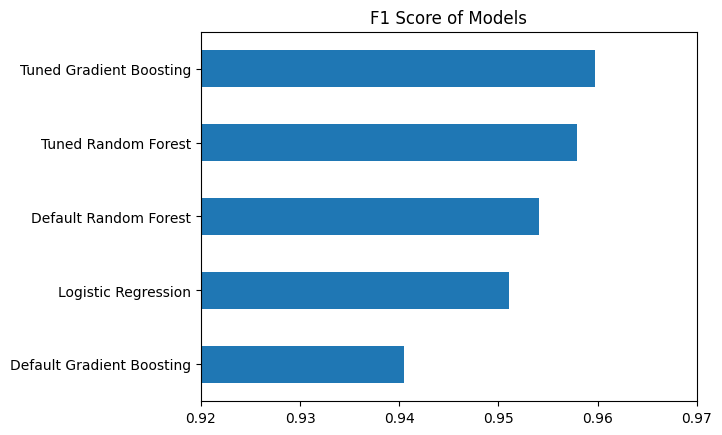

In [ ]:
pd.DataFrame([ 0.9404461253682722,0.9510988077025813, 0.9540434406472142, 0.9578815406321033, 0.9597472797472797],
             index=[ 'Default Gradient Boosting','Logistic Regression', 'Default Random Forest', 'Tuned Random Forest', 'Tuned Gradient Boosting']).plot.barh(title='F1 Score of Models', legend=False, xlim=[0.92, 0.97])

**Which factors affect the risk for lung cancer?**

<Axes: title={'center': 'Coefficient Values for the Logistic Model'}>

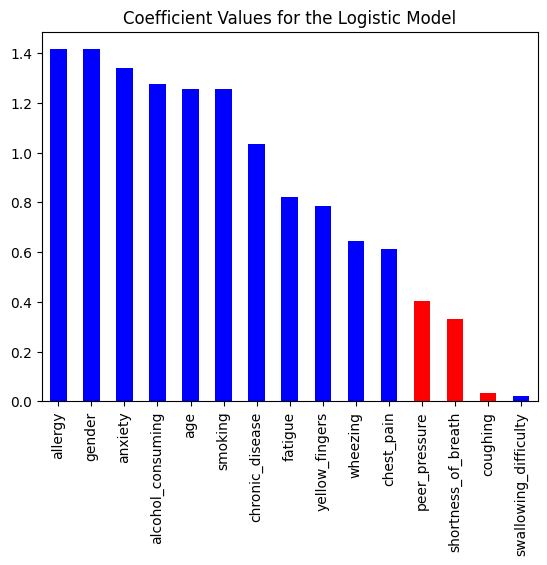

In [ ]:
model = LogisticRegression(solver='liblinear', max_iter=1000)

model.fit(X_train, y_train)
coefs = pd.Series(model.coef_[0], index=['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety', 'peer_pressure', 'chronic_disease', 'fatigue', 'allergy', 'wheezing', 'alcohol_consuming', 'coughing', 'shortness_of_breath', 'swallowing_difficulty', 'chest_pain'])

coefs_clean = pd.DataFrame(coefs, columns=['coef'])
coefs_clean['pos'] = coefs_clean['coef'].apply(lambda x: 'b' if x > 0 else 'r')
coefs.apply(abs).sort_values(ascending=False).plot.bar(color=coefs_clean['pos'], title='Coefficient Values for the Logistic Model')